# Assignment 1 - mkecera3@gatech.edu

## Import libraries

In [160]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import torch.nn.functional as F
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
# import time

In [2]:
# structure to save accuracy results
allAccuracy = []

In [3]:
savePath = ''

## Load and save the datasets

Start of citation - the following code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [154]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

## Neural network

### MNIST dataset

In [155]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [156]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [157]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [162]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [163]:
lossDataBaseline, accDataBaseline, runtime = trainNN(model)

Epoch 0 - Training loss: 0.7269260317582609
Testing Loss  = 0.3329546243711642
Epoch 1 - Training loss: 0.2957466525094741
Testing Loss  = 0.293006590692101
Epoch 2 - Training loss: 0.2346985718935652
Testing Loss  = 0.22358315912591423
Epoch 3 - Training loss: 0.19242993946356313
Testing Loss  = 0.1843881084447264
Epoch 4 - Training loss: 0.1623184769164266
Testing Loss  = 0.1771906071882339
Epoch 5 - Training loss: 0.1407649290969457
Testing Loss  = 0.1590858826734078
Epoch 6 - Training loss: 0.1223714373662801
Testing Loss  = 0.14688102216430152
Epoch 7 - Training loss: 0.10908576318293886
Testing Loss  = 0.12994390007132178
Epoch 8 - Training loss: 0.09756823210760265
Testing Loss  = 0.12533973618914748
Epoch 9 - Training loss: 0.08667569270100245
Testing Loss  = 0.11617063611425507
Epoch 10 - Training loss: 0.07898470457962445
Testing Loss  = 0.1062175385345509
Epoch 11 - Training loss: 0.07180682164521607
Testing Loss  = 0.10550572331045653
Epoch 12 - Training loss: 0.06629216556

In [237]:
print(np.mean(runtime))
# print(runtime)

2.7324236392974854


In [165]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [166]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

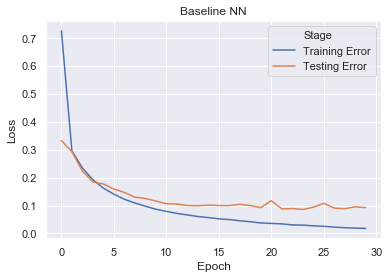

In [167]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 Baseline NN')

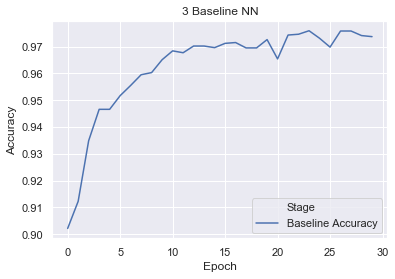

In [168]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 Baseline NN')

In [169]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [170]:
correctCount / allCount

0.9776

In [171]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_complex = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [172]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_complex(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [173]:
lossDataComplex, accDataComplex, runtime = trainNN(model_complex)

Epoch 0 - Training loss: 0.9169804424885899
Testing Loss  = 0.3621988543279611
Epoch 1 - Training loss: 0.3133155627228567
Testing Loss  = 0.2723660528375085
Epoch 2 - Training loss: 0.22885709027271442
Testing Loss  = 0.20888309617331074
Epoch 3 - Training loss: 0.17698250220292974
Testing Loss  = 0.16712255431873024
Epoch 4 - Training loss: 0.14247004861426552
Testing Loss  = 0.16368825949586122
Epoch 5 - Training loss: 0.11862269718357174
Testing Loss  = 0.13346323512114916
Epoch 6 - Training loss: 0.10346286295486799
Testing Loss  = 0.12570813763293492
Epoch 7 - Training loss: 0.08977619395889055
Testing Loss  = 0.11632439140586337
Epoch 8 - Training loss: 0.07992200263331661
Testing Loss  = 0.11195705958292078
Epoch 9 - Training loss: 0.07093302197301822
Testing Loss  = 0.109733161913931
Epoch 10 - Training loss: 0.062390687690257
Testing Loss  = 0.09390916944938196
Epoch 11 - Training loss: 0.056377166106551406
Testing Loss  = 0.10792018793772455
Epoch 12 - Training loss: 0.05061

In [174]:
accDataComplex = [[row[0], row[1], 'More nodes and layers Accuracy'] for row in accDataComplex]

In [175]:
lossDataComplex = pd.DataFrame.from_records(lossDataComplex, columns=["Epoch", "Loss", "Stage"])
accDataComplex = pd.DataFrame.from_records(accDataComplex, columns=["Epoch", "Accuracy", "Stage"])

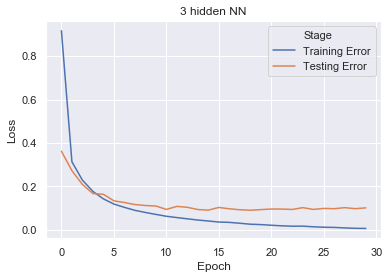

In [176]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataComplex
#     ).set_title('3 hidden NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataComplex
    ).set_title('3 hidden NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_3hidden_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 hidden NN')

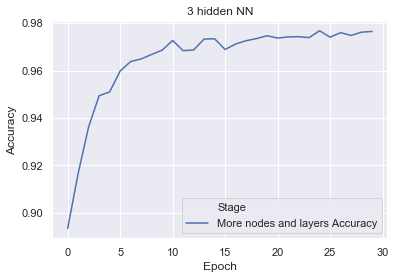

In [177]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataComplex
    ).set_title('3 hidden NN')

End of citation - the preceding code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627





In [178]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [179]:
correctCount / allCount

0.9785

In [180]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_dropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [181]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_dropout(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [182]:
lossDataDropout, accDataDropout, runtime = trainNN(model_dropout)

Epoch 0 - Training loss: 0.9837602718978586
Testing Loss  = 0.41809179572163113
Epoch 1 - Training loss: 0.32342445149617577
Testing Loss  = 0.2738310822350964
Epoch 2 - Training loss: 0.23296121727017796
Testing Loss  = 0.22936159754349927
Epoch 3 - Training loss: 0.18512697178689416
Testing Loss  = 0.18121297265978376
Epoch 4 - Training loss: 0.15416981806964292
Testing Loss  = 0.16746529618835754
Epoch 5 - Training loss: 0.13300056443752153
Testing Loss  = 0.15957269219646028
Epoch 6 - Training loss: 0.12006946555469804
Testing Loss  = 0.13882812385441393
Epoch 7 - Training loss: 0.10958744729023494
Testing Loss  = 0.1317587308437344
Epoch 8 - Training loss: 0.09886424899067911
Testing Loss  = 0.13015366524196925
Epoch 9 - Training loss: 0.09240863209559351
Testing Loss  = 0.12764484941911924
Epoch 10 - Training loss: 0.0838716880851866
Testing Loss  = 0.1267060044808847
Epoch 11 - Training loss: 0.07757755995893617
Testing Loss  = 0.12593039278249452
Epoch 12 - Training loss: 0.072

In [183]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]

In [184]:
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

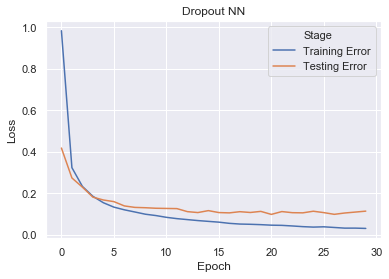

In [185]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataDropout
#     ).set_title('Dropout NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_dropout_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Dropout NN')

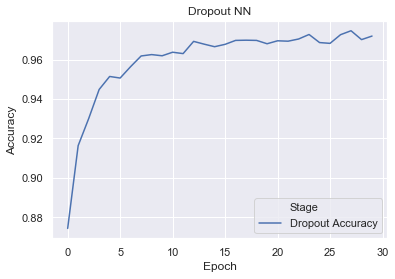

In [186]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [187]:
accData = accDataBaseline.copy()
accData = accData.append(accDataComplex)
accData = accData.append(accDataDropout)

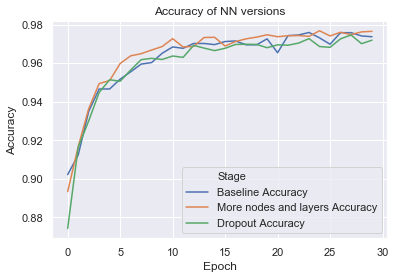

In [188]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Accuracy",
#     hue="Stage",
#     data=accData
#     ).set_title('Accuracy of NN versions')

sns_plot = sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_all_accuracy.png", dpi=100)

In [189]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [190]:
correctCount / allCount

0.9785

In [191]:
allAccuracy.append(['Neural Network', 'MNIST', correctCount / allCount])

,0,Accuracy,Algorithm,Dataset
0,NaN,0.977900,Neural Network,MNIST
1,NaN,0.717954,Neural Network,Credit
2,NaN,0.883300,Decision Tree,MNIST
3,NaN,0.803017,Decision Tree,Credit
4,NaN,0.973000,Boosting,MNIST
5,NaN,0.923818,Boosting,Credit
6,NaN,0.969100,KNN,MNIST
7,NaN,0.849882,KNN,Credit
8,NaN,0.979700,SVM,MNIST
9,NaN,0.662529,SVM,Credit


### Credit default dataset

In [192]:
# load dataset
creditDataDf = pd.read_excel(savePath + './data/default of credit card clients.xls', header=1)
creditDataDf = creditDataDf.drop(columns=['ID'])

In [193]:
print(sum(creditDataDf['default payment next month']))
print(len(creditDataDf))
print(sum(creditDataDf['default payment next month'])/len(creditDataDf))


6636
30000
0.2212


In [194]:
# create dummy variables from categorical
creditDataDf = pd.get_dummies(creditDataDf, prefix=['SEX', 'EDUCATION', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [195]:
# drop last mummy variable
creditDataDf = creditDataDf.drop(columns=['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'])

In [196]:
y = creditDataDf['default payment next month']
creditDataDf = creditDataDf.drop(columns=['default payment next month'])

In [197]:
dfColumns = creditDataDf.columns

In [198]:
# balance the dataset
ros = RandomOverSampler(random_state=37)
creditDataDf, y = ros.fit_resample(creditDataDf, y)

In [199]:
creditDataDf = pd.DataFrame(creditDataDf, columns=dfColumns)

In [200]:
print(sum(y)/len(y))

0.5


In [201]:
# normalize the data
x = creditDataDf.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
creditDataDf = pd.DataFrame(x_scaled, columns=creditDataDf.columns)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(creditDataDf, y, test_size=0.2, random_state=37)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=37)

In [203]:
print(X_train.columns)
print(len(X_train.columns))

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2'],
      dtype='object')
30


In [204]:
sum(y_train)/len(y_train)

0.5023909045310149

In [205]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val.values.astype(np.float32))

y_train_tensor = torch.tensor(y_train.values.astype(np.int))
y_test_tensor = torch.tensor(y_test.values.astype(np.int))
y_val_tensor = torch.tensor(y_val.values.astype(np.int))

In [206]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [207]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

7477 9346 29905


In [208]:
trainloader2 = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader2 = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader2 = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [209]:
def nnPredictTabular(model2, valloader2, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    probList = []
    for rows,labels in valloader2:
        
#         print(rows.shape)
#         print(labels.shape)
        
        with torch.no_grad():
                output = model2(rows)
                loss = criterion(output, labels)
                running_loss += loss.item()


        for i in range(len(labels)):
            row = rows[i].view(1, 30)
#             print(row.shape)
            with torch.no_grad():
                logps = model2(row)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            probList.append(probab)
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader2)))
    
    return running_loss/len(valloader2), correct_count, all_count, probList

In [210]:
input_size = 30
hidden_sizes = [25, 15]
output_size = 2

modelTabBaseline = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [211]:
def trainTabNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # optimizer = optim.Adam(model.parameters(), lr=0.01)
    time0 = time()
    epochs = 100
    lossData = []
    accData=[]
    runTime = []
    for e in range(epochs):
        startTime = time()
        running_loss = 0
        for rows, labels in trainloader2:
                
            # Training pass
            optimizer.zero_grad()
            
            output = model(rows)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader2)))
            
        testingLoss, correctCount, allCount, proba = nnPredictTabular(model, valloader2, criterion)
        print("Testing Loss  =", (testingLoss))
        print("Testing Accuracy  =", (correctCount / allCount))
        
        lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
        lossData.append([e, testingLoss, 'Testing Loss'])
        accData.append([e, correctCount / allCount])

        runTime.append(time() - startTime)
    
    return lossData, accData, runTime
        
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [212]:
lossDataBaseline, accDataBaseline, runtime = trainTabNN(modelTabBaseline)

Epoch 0 - Training loss: 0.6628905030397269
Testing Loss  = 0.6238288283348083
Testing Accuracy  = 0.6445098301457803
Epoch 1 - Training loss: 0.607961482153489
Testing Loss  = 0.5929079651832581
Testing Accuracy  = 0.68449913066738
Epoch 2 - Training loss: 0.5912316214834523
Testing Loss  = 0.5818366408348083
Testing Accuracy  = 0.6997458873879898
Epoch 3 - Training loss: 0.5840764473009313
Testing Loss  = 0.576573371887207
Testing Accuracy  = 0.7037581917881504
Epoch 4 - Training loss: 0.5793076305944695
Testing Loss  = 0.5727577805519104
Testing Accuracy  = 0.7034907048281396
Epoch 5 - Training loss: 0.5766624381017481
Testing Loss  = 0.5693840384483337
Testing Accuracy  = 0.7048281396281931
Epoch 6 - Training loss: 0.5739900934645253
Testing Loss  = 0.5666993856430054
Testing Accuracy  = 0.7037581917881504
Epoch 7 - Training loss: 0.57132827070279
Testing Loss  = 0.5644649267196655
Testing Accuracy  = 0.7077704961883108
Epoch 8 - Training loss: 0.5697004176103152
Testing Loss  = 0.

In [238]:
print(np.mean(runtime))
# print(runtime)

2.7324236392974854


In [214]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabBaseline, testloader2, criterion)

In [215]:
correctCount/allCount

0.725872030815322

In [216]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

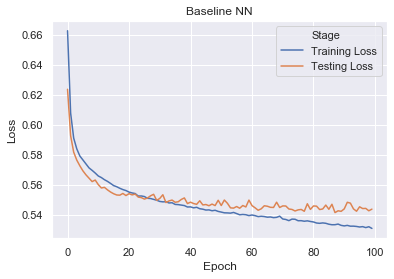

In [217]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Baseline NN')

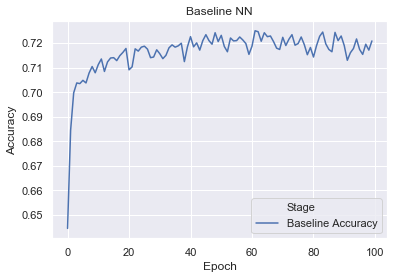

In [218]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Baseline NN')

In [219]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2

modelTabLarge = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [220]:
lossDataLarge, accDataLarge, runtime = trainTabNN(modelTabLarge)

Epoch 0 - Training loss: 0.6937959894665287
Testing Loss  = 0.6930854916572571
Testing Accuracy  = 0.49565333689982616
Epoch 1 - Training loss: 0.6930470406754404
Testing Loss  = 0.6929750442504883
Testing Accuracy  = 0.5268155677410726
Epoch 2 - Training loss: 0.6929800488755234
Testing Loss  = 0.6928607225418091
Testing Accuracy  = 0.5048816370201953
Epoch 3 - Training loss: 0.6928747027602971
Testing Loss  = 0.6932467818260193
Testing Accuracy  = 0.4951183629798047
Epoch 4 - Training loss: 0.6928014533642011
Testing Loss  = 0.6926801204681396
Testing Accuracy  = 0.4987294369399492
Epoch 5 - Training loss: 0.6924020808476669
Testing Loss  = 0.6925289630889893
Testing Accuracy  = 0.4951183629798047
Epoch 6 - Training loss: 0.6918044357727735
Testing Loss  = 0.6913918852806091
Testing Accuracy  = 0.5044804065801792
Epoch 7 - Training loss: 0.6903504972529207
Testing Loss  = 0.6890865564346313
Testing Accuracy  = 0.5427310418617093
Epoch 8 - Training loss: 0.6856686300956286
Testing Los

In [221]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, testloader2, criterion)

In [222]:
correctCount/allCount

0.706826449818104

In [223]:
accDataLarge = [[row[0], row[1], '5 hidden Accuracy'] for row in accDataLarge]
lossDataLarge = pd.DataFrame.from_records(lossDataLarge, columns=["Epoch", "Loss", "Stage"])
accDataLarge = pd.DataFrame.from_records(accDataLarge, columns=["Epoch", "Accuracy", "Stage"])

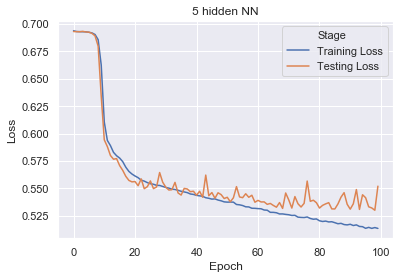

In [224]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataLarge
    # ).set_title('5 hidden NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataLarge
    ).set_title('5 hidden NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_5hidden_learning-curve.png", dpi=100)

Text(0.5, 1.0, '5 hidden NN')

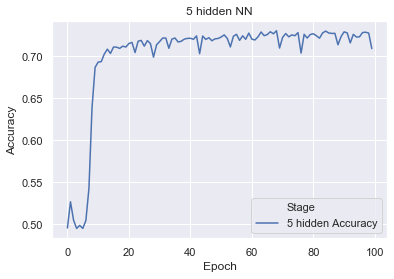

In [225]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataLarge
    ).set_title('5 hidden NN')

In [226]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2
drop_out = 0.2

modelTabDropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [227]:
lossDataDropout, accDataDropout, runtime = trainTabNN(modelTabDropout)

Epoch 0 - Training loss: 0.6934716813584678
Testing Loss  = 0.6930261850357056
Testing Accuracy  = 0.5090276849003611
Epoch 1 - Training loss: 0.6931209454679081
Testing Loss  = 0.6929959654808044
Testing Accuracy  = 0.5316303330212652
Epoch 2 - Training loss: 0.6930281365783806
Testing Loss  = 0.6928388476371765
Testing Accuracy  = 0.5347064330613882
Epoch 3 - Training loss: 0.6929246995948318
Testing Loss  = 0.6927782893180847
Testing Accuracy  = 0.5258793633810351
Epoch 4 - Training loss: 0.69276190835696
Testing Loss  = 0.6926820874214172
Testing Accuracy  = 0.5210645981008426
Epoch 5 - Training loss: 0.6925430119547069
Testing Loss  = 0.6923254132270813
Testing Accuracy  = 0.5075565066203023
Epoch 6 - Training loss: 0.6921602920589284
Testing Loss  = 0.6919658184051514
Testing Accuracy  = 0.49913066737996525
Epoch 7 - Training loss: 0.6913073050160693
Testing Loss  = 0.6903809905052185
Testing Accuracy  = 0.5750969640230039
Epoch 8 - Training loss: 0.6890766567144638
Testing Loss 

In [228]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabDropout, testloader2, criterion)

In [229]:
correctCount/allCount

0.7135673015193665

In [230]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

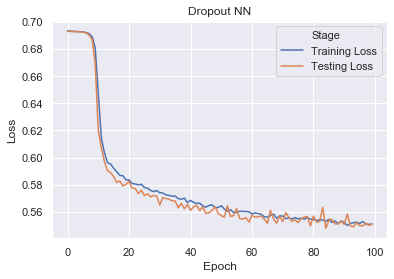

In [231]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataDropout
#     ).set_title('Dropout NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_dropout_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Dropout NN')

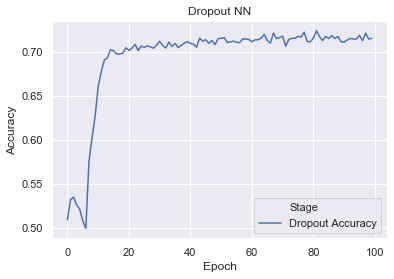

In [232]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [233]:
accData = accDataBaseline.copy()
accData = accData.append(accDataLarge)
accData = accData.append(accDataDropout)

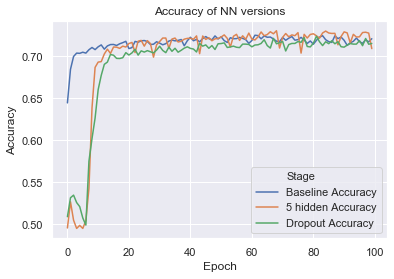

In [234]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Accuracy",
#     hue="Stage",
#     data=accData
#     ).set_title('Accuracy of NN versions')

sns_plot = sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_all_accuracy.png", dpi=100)

In [235]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, testloader2, criterion)

In [236]:
allAccuracy.append(['Neural Network', 'Credit', correctCount / allCount])

,0,Accuracy,Algorithm,Dataset
0,NaN,0.977900,Neural Network,MNIST
1,NaN,0.717954,Neural Network,Credit
2,NaN,0.883300,Decision Tree,MNIST
3,NaN,0.803017,Decision Tree,Credit
4,NaN,0.973000,Boosting,MNIST
5,NaN,0.923818,Boosting,Credit
6,NaN,0.969100,KNN,MNIST
7,NaN,0.849882,KNN,Credit
8,NaN,0.979700,SVM,MNIST
9,NaN,0.662529,SVM,Credit


## Decision tree

### MNIST dataset

In [81]:
trainset = datasets.MNIST('./data', download=False, train=True, transform=transform)
testset = datasets.MNIST('./data', download=False, train=False, transform=transform)

In [82]:
X_train_MNIST = trainset.data.numpy()
X_test_MNIST = testset.data.numpy()

In [83]:
y_train_MNIST = trainset.targets.numpy()
y_test_MNIST = testset.targets.numpy()

In [84]:
np.bincount(y_train_MNIST) + np.bincount(y_test_MNIST)

array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958])

In [85]:
print(X_train_MNIST.shape)
print(y_train_MNIST.shape)

(60000, 28, 28)
(60000,)


In [86]:
X_train_MNIST_reshaped = X_train_MNIST.reshape((60000, 784))
X_test_MNIST_reshaped = X_test_MNIST.reshape((10000, 784))

In [87]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
gridSearchTree.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 13.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 

In [88]:
gridSearchTree.best_params_

{'max_depth': 15, 'min_samples_leaf': 5}

In [89]:
preds = gridSearchTree.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

0.8833


In [90]:
allAccuracy.append(['Decision Tree', 'MNIST', accuracy_score(preds, y_test_MNIST)])

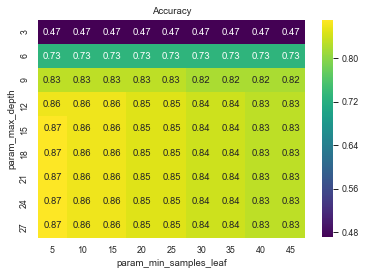

In [91]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_CV_accuracy.png", dpi=100)

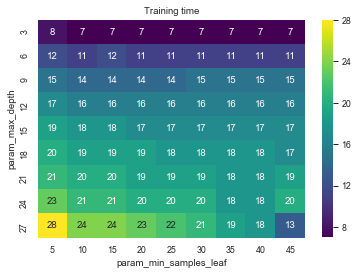

In [92]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 0)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_CV_train-time.png", dpi=100)

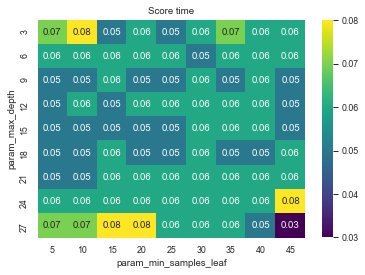

In [93]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_CV_score-time.png", dpi=100)

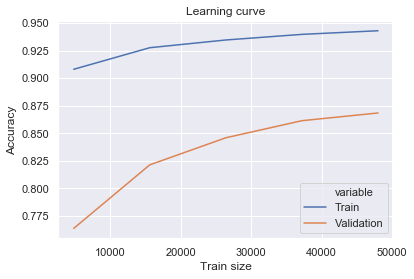

In [94]:
bestModel = tree.DecisionTreeClassifier(**gridSearchTree.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')
sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_learning-curve.png", dpi=100)

### Credit default dataset

In [95]:
np.bincount(y_train) + np.bincount(y_test) + np.bincount(y_val)

array([23364, 23364])

In [96]:
# concatenate dfs
X_train = pd.concat([X_train,X_val], axis=0)
y_train = np.concatenate([y_train,y_val], axis=0)
print(X_train.shape)
print(y_train.shape)

(37382, 30)
(37382,)


In [97]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=2, scoring='accuracy'
    )
gridSearchTree.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   26.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 

In [98]:
preds = gridSearchTree.predict(X_test)
probs = gridSearchTree.predict_proba(X_test)
print(accuracy_score(preds, y_test))

0.8030173336186603


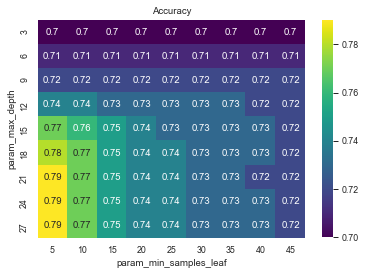

In [99]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_accuracy.png", dpi=100)

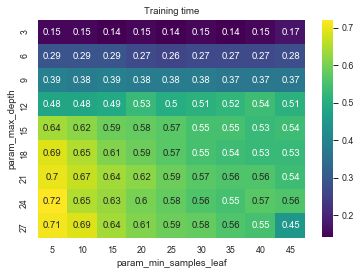

In [100]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_training-time.png", dpi=100)

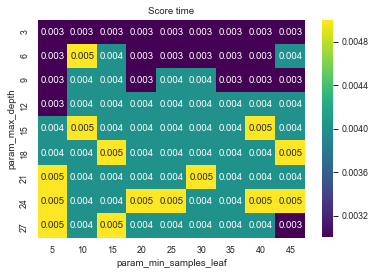

In [101]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_score-time.png", dpi=100)

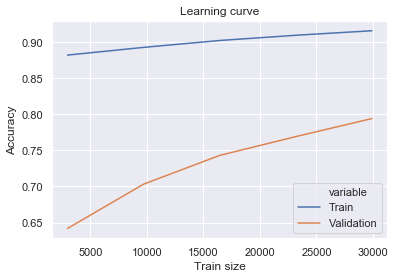

In [102]:
bestModel = tree.DecisionTreeClassifier(**gridSearchTree.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_learning-curve.png", dpi=100)

In [103]:
preds = gridSearchTree.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['Decision Tree', 'Credit', accuracy_score(preds, y_test)])

0.8030173336186603


In [104]:
print(allAccuracy)

[['Neural Network', 'MNIST', 0.9779], ['Neural Network', 'Credit', 0.7179542050074899], ['Decision Tree', 'MNIST', 0.8833], ['Decision Tree', 'Credit', 0.8030173336186603]]


## Boosting

### MNIST

In [105]:
param_grid = {'max_depth': np.arange(5, 30, 5), 'n_estimators': np.arange(10, 50, 10) }
gridSearchBoosting = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3, tree_method='hist', nthread=4), param_grid, n_jobs=4, verbose=3, scoring='accuracy', cv=2
    )
gridSearchBoosting.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 36.9min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 71.2min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25]),
                         'n_estimators': array([10, 20, 30,

In [106]:
gridSearchBoosting.best_params_

{'max_depth': 10, 'n_estimators': 40}

In [107]:
preds = gridSearchBoosting.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['Boosting', 'MNIST', accuracy_score(preds, y_test_MNIST)])

0.973


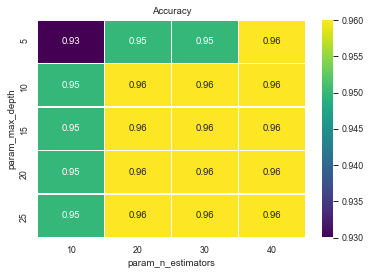

In [108]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_accuracy.png", dpi=100)

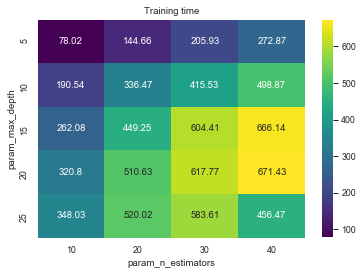

In [109]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_train-time", dpi=100)

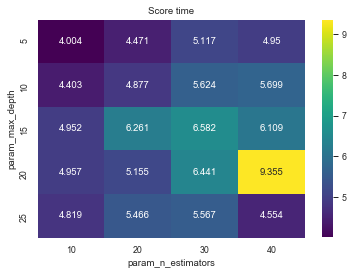

In [110]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_score-time.png", dpi=100)

In [111]:
bestModel = xgb.XGBClassifier(**gridSearchBoosting.best_params_, nthreads=4)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=4,
                                            verbose=5
                                            )

[learning_curve] Training set sizes: [ 3000  9750 16500 23250 30000]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of  10 | elapsed:  4.7min remaining: 18.6min
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed: 10.6min remaining: 10.6min
[Parallel(n_jobs=4)]: Done   8 out of  10 | elapsed: 15.7min remaining:  3.9min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 24.1min finished


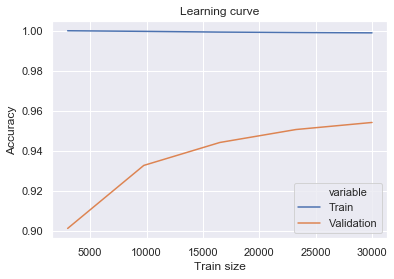

In [112]:
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_learning-curve.png", dpi=100)

### Credit default

In [113]:
param_grid = {'max_depth': np.arange(5, 30, 5), 'n_estimators': np.arange(10, 50, 10) }
gridSearchBoosting = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3, tree_method='hist', nthread=4), param_grid, n_jobs=4, verbose=3, scoring='accuracy', cv=2
    )
gridSearchBoosting.fit(X_train, y_train)


Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   27.5s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25]),
                         'n_estimators': array([10, 20, 30,

In [114]:
preds = gridSearchBoosting.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['Boosting', 'Credit', accuracy_score(preds, y_test)])
print(gridSearchBoosting.best_params_)

0.9238176760111277
{'max_depth': 25, 'n_estimators': 40}


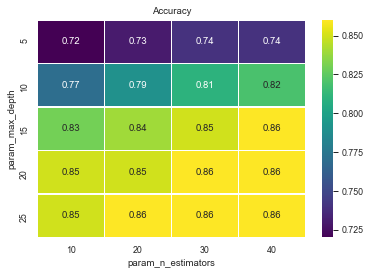

In [115]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_accuracy.png", dpi=100)

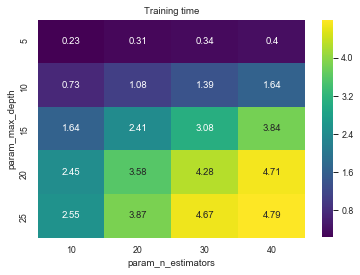

In [116]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_training-time.png", dpi=100)

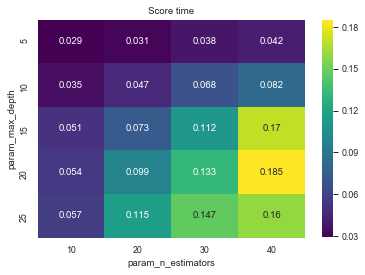

In [117]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_score-time.png", dpi=100)

In [118]:
bestModel = xgb.XGBClassifier(**gridSearchBoosting.best_params_, nthreads=4)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=4,
                                            verbose=5
                                            )

[learning_curve] Training set sizes: [ 1869  6074 10280 14485 18691]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of  10 | elapsed:    2.2s remaining:    9.0s
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    5.1s remaining:    5.1s
[Parallel(n_jobs=4)]: Done   8 out of  10 | elapsed:    8.2s remaining:    2.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   12.9s finished


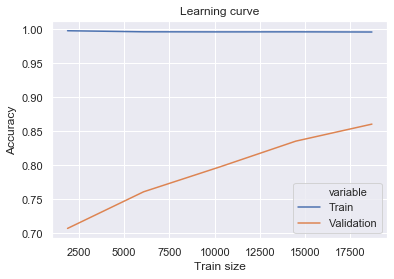

In [119]:
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_learning-curve.png", dpi=100)

In [120]:
print(allAccuracy)

[['Neural Network', 'MNIST', 0.9779], ['Neural Network', 'Credit', 0.7179542050074899], ['Decision Tree', 'MNIST', 0.8833], ['Decision Tree', 'Credit', 0.8030173336186603], ['Boosting', 'MNIST', 0.973], ['Boosting', 'Credit', 0.9238176760111277]]


## KNN

### MNIST

In [121]:
param_grid = {'n_neighbors': np.arange(5, 25, 5), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
kNN.fit(X_train_MNIST_reshaped, y_train_MNIST)

preds = kNN.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['KNN', 'MNIST', accuracy_score(preds, y_test_MNIST)])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed: 110.4min remaining: 36.8min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 110.5min finished
0.9691


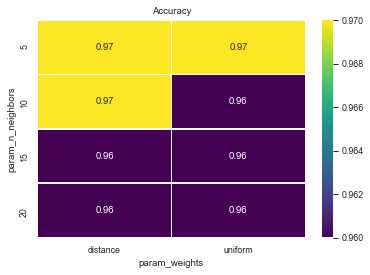

In [122]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResultsScore[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_accuracy.png", dpi=100)

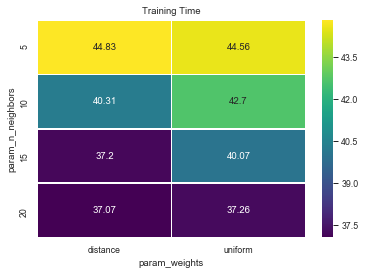

In [123]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_n_neighbors', columns='param_weights', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_training-time.png", dpi=100)

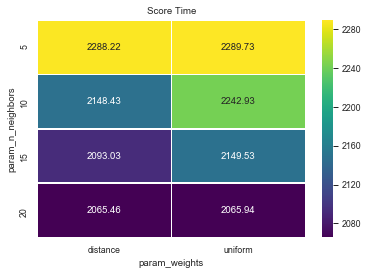

In [124]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_score-time.png", dpi=100)

In [125]:
allAccuracy

[['Neural Network', 'MNIST', 0.9779],
 ['Neural Network', 'Credit', 0.7179542050074899],
 ['Decision Tree', 'MNIST', 0.8833],
 ['Decision Tree', 'Credit', 0.8030173336186603],
 ['Boosting', 'MNIST', 0.973],
 ['Boosting', 'Credit', 0.9238176760111277],
 ['KNN', 'MNIST', 0.9691]]

[learning_curve] Training set sizes: [ 3000  9750 16500 23250 30000]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  3.7min remaining: 14.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 30.5min remaining: 30.5min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed: 41.6min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 50.9min finished


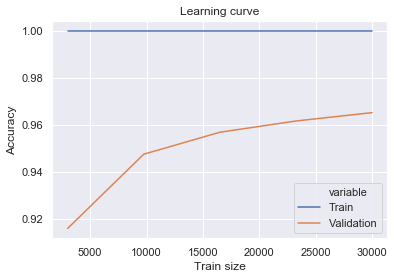

In [126]:
bestModel = KNeighborsClassifier(**kNN.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=-1,
                                            verbose=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_learning-curve.png", dpi=100)

### Credit default

In [127]:
param_grid = {'n_neighbors': np.arange(5, 25, 5), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
kNN.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  2.1min remaining:   41.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 5, 10, 15, 20]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [128]:
preds = kNN.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['KNN', 'Credit', accuracy_score(preds, y_test)])

0.849882302589343


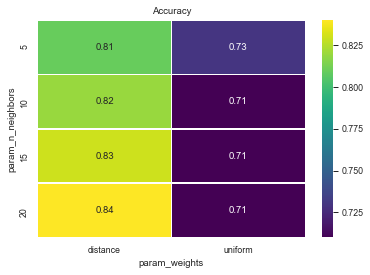

In [129]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResultsScore[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_accuracy.png", dpi=100)

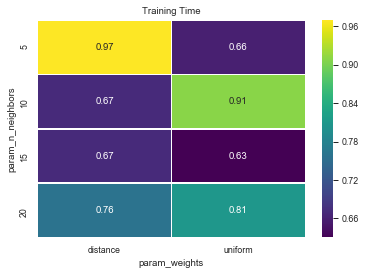

In [130]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_n_neighbors', columns='param_weights', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_training-time.png", dpi=100)

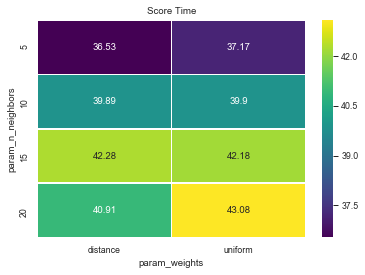

In [131]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_score-time.png", dpi=100)

[learning_curve] Training set sizes: [ 1869  6074 10280 14485 18691]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   13.4s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   47.9s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


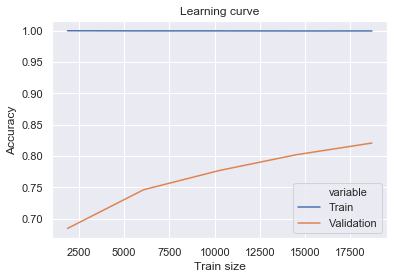

In [132]:
bestModel = KNeighborsClassifier(**kNN.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=-1,
                                            verbose=3
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_learning-curve.png", dpi=100)

## SVM

### MNIST

In [133]:
param_grid = {'kernel': ['poly', 'rbf', 'linear'], 'max_iter': [10, 500, 2000]}
SVM = GridSearchCV(
    svm.SVC(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
SVM.fit(X_train_MNIST_reshaped, y_train_MNIST)

preds = SVM.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['SVM', 'MNIST', accuracy_score(preds, y_test_MNIST)])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/anaconda3/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed: 28.9min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 34.2min finished
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
0.9797


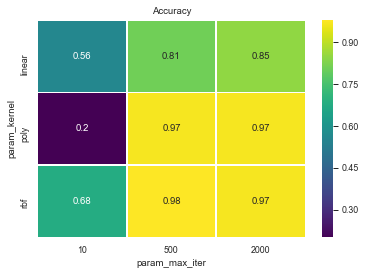

In [134]:
cvResultsScore = pd.DataFrame(SVM.cv_results_)
cvResultsScore = cvResultsScore[['param_kernel', 'param_max_iter', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_accuracy.png", dpi=100)

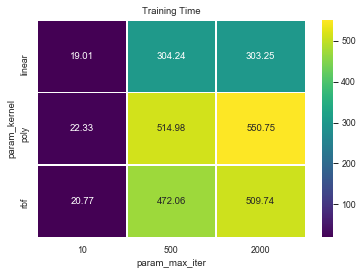

In [135]:
cvResultsTimeTrain = pd.DataFrame(SVM.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_kernel', 'param_max_iter', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_kernel', columns='param_max_iter', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_training-time.png", dpi=100)

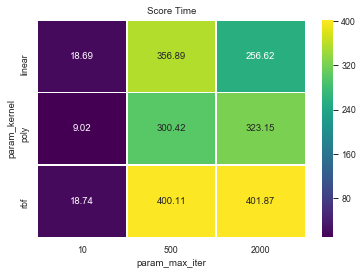

In [136]:
cvResultsTimeScore = pd.DataFrame(SVM.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_kernel', 'param_max_iter', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_score-time.png", dpi=100)

[learning_curve] Training set sizes: [ 4000 13000 22000 31000 40000]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  6.9min remaining: 19.0min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 13.9min remaining: 12.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 23.7min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 29.5min finished


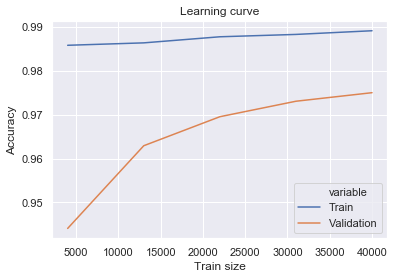

In [137]:
bestModel = svm.SVC(**SVM.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=3,
                                            n_jobs=-1,
                                            verbose=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_learning-curve.png", dpi=100)

### Credit default

In [138]:
param_grid = {'kernel': ['poly', 'rbf', 'linear'], 'max_iter': [10, 500, 2000, 10000, 30000]}
SVM = GridSearchCV(
    svm.SVC(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
SVM.fit(X_train, y_train)

preds = SVM.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['SVM', 'Credit', accuracy_score(preds, y_test)])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.7min finished
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
0.6625294243526643


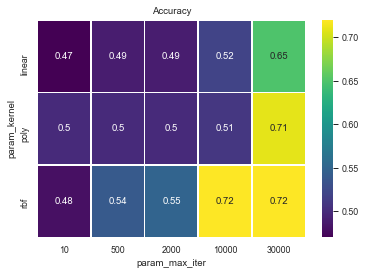

In [139]:
cvResultsScore = pd.DataFrame(SVM.cv_results_)
cvResultsScore = cvResultsScore[['param_kernel', 'param_max_iter', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_accuracy.png", dpi=100)

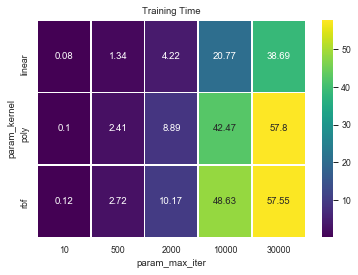

In [140]:
cvResultsTimeTrain = pd.DataFrame(SVM.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_kernel', 'param_max_iter', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_kernel', columns='param_max_iter', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_training-time.png", dpi=100)

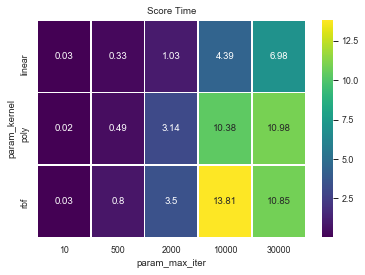

In [141]:
cvResultsTimeScore = pd.DataFrame(SVM.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_kernel', 'param_max_iter', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_score-time.png", dpi=100)

[learning_curve] Training set sizes: [ 2492  8099 13706 19313 24921]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   14.9s remaining:   40.8s
/anaconda3/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   33.8s remaining:   29.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.2min remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished


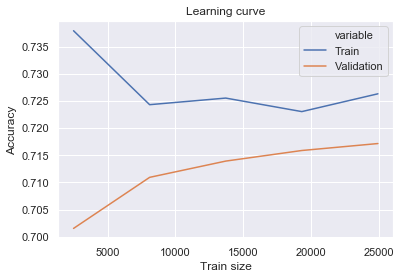

In [142]:
bestModel = svm.SVC(**SVM.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=3,
                                            n_jobs=-1,
                                            verbose=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_learning-curve.png", dpi=100)

In [143]:
print(allAccuracy)

[['Neural Network', 'MNIST', 0.9779], ['Neural Network', 'Credit', 0.7179542050074899], ['Decision Tree', 'MNIST', 0.8833], ['Decision Tree', 'Credit', 0.8030173336186603], ['Boosting', 'MNIST', 0.973], ['Boosting', 'Credit', 0.9238176760111277], ['KNN', 'MNIST', 0.9691], ['KNN', 'Credit', 0.849882302589343], ['SVM', 'MNIST', 0.9797], ['SVM', 'Credit', 0.6625294243526643]]


In [144]:
# allAccuracy = [
#     ['Neural Network', 'MNIST', 0.9806], 
#     ['Neural Network', 'Credit', 0.7261930237534774], 
#     ['Decision Tree', 'MNIST', 0.8836], 
#     ['Decision Tree', 'Credit', 0.8031243312647122],
#     ['Boosting', 'MNIST', 0.973], 
#     ['Boosting', 'Credit', 0.9033811256152364],
#     ['KNN', 'MNIST', 0.9691], 
#     ['KNN', 'Credit', 0.8400385191525787], 
#     ['SVM', 'MNIST', 0.979], 
#     ['SVM', 'Credit', 0.66252]
#     ]

In [145]:
allAccuracy = pd.DataFrame(
    allAccuracy,
    columns=['Algorithm', 'Dataset', 'Accuracy']
)

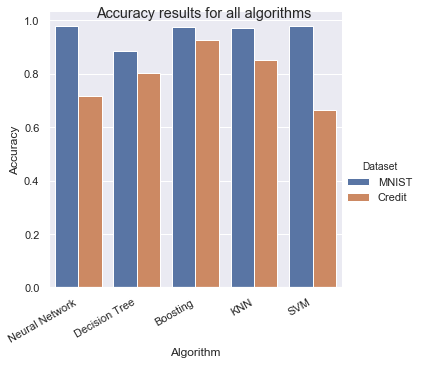

In [146]:
sns.set(
    style="darkgrid"
    )

sns_plot = sns.catplot(
    x="Algorithm", y="Accuracy",
    hue="Dataset",
    data=allAccuracy,
    kind='bar'
    )
    
sns_plot.fig.suptitle('Accuracy results for all algorithms')
# sns_plot.ax.set_xticklabels(sns_plot.ax.get_xticklabels(), rotation=90, ha="right")
sns_plot.fig.autofmt_xdate()
    
sns_plot.fig.savefig(savePath + "all_results.png", dpi=100)

# END